## Introduction:

The prediction model aims to stack the results of 5 different models, namely:
- Sequential neural network
- K-nearest neighbors classifier
- Elastic net logistic regression
- Random forest
- Extreme gradient boosting

Assumptions used in feature engineering:
- Maximum trip length is 130 minutes. Those timestamps with more than 6,000,000 seconds are removed.
- Maximum speed is 40 m/s
- Accuracy of 65 is of WiFi GPS, and accuracy of 1414 is of cell tower GPS.
- For label data, a trip which is labelled as both safe and dangerous is relablled as dangerous.

## 1. Load libraries and datasets:

Load commonly used libraries

In [1]:
import pandas as pd
import numpy as np
import random
import datetime
import tensorflow as tf
import dill # To save workspace

Load 10 of our features datasets, and append them together:

In [2]:
%%time
features_data = pd.read_csv('./features/part-00000-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv')
for index in range(1, 10):
    file_link = './features/part-0000' + str(index) + '-e6120af0-10c2-4248-97c4-81baf4304e5c-c000.csv'
    for chunk in pd.read_csv(file_link, chunksize = 10000):
        features_data = features_data.append(chunk, ignore_index = True)

Wall time: 5min 17s


Check summary statistics:

In [3]:
sum_stats = features_data.describe()
sum_stats

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
count,1.613556e+07,1.613556e+07,1.613556e+07,1.613556e+07,1.613556e+07,1.613556e+07,1.613556e+07,1.613556e+07,1.613556e+07,1.613556e+07,1.613556e+07
mean,8.184819e+11,1.161035e+01,1.689684e+02,6.914529e-02,4.468976e+00,8.942974e-01,-1.710847e-03,2.800733e-04,-2.569688e-04,3.803484e+03,9.006543e+00
std,4.952476e+11,8.691672e+01,1.072966e+02,1.424161e+00,8.130664e+00,3.251549e+00,1.445619e-01,3.400630e-01,1.480824e-01,1.436686e+06,8.106415e+00
min,0.000000e+00,7.500000e-01,0.000000e+00,-7.841969e+01,-7.299412e+01,-7.844842e+01,-4.845575e+01,-7.488861e+01,-5.355445e+01,0.000000e+00,-2.000000e+00
25%,3.779571e+11,3.900000e+00,7.800000e+01,-5.081238e-01,-2.022476e+00,-9.316101e-01,-2.678888e-02,-2.993851e-02,-1.876500e-02,2.410000e+02,1.020000e+00
50%,8.074539e+11,4.250000e+00,1.688700e+02,6.137085e-02,9.081485e+00,7.757450e-01,-6.432411e-04,2.645046e-04,-3.542004e-05,5.200000e+02,7.530000e+00
75%,1.254130e+12,8.000000e+00,2.629840e+02,6.350620e-01,9.709778e+00,2.750938e+00,2.330639e-02,3.143085e-02,1.823425e-02,8.630000e+02,1.548000e+01
max,1.709397e+12,6.070101e+03,3.599995e+02,6.687346e+01,7.505589e+01,7.805576e+01,3.983975e+01,8.031496e+01,6.630078e+01,1.495797e+09,1.480186e+02


In [4]:
features_data.dtypes

bookingID           int64
Accuracy          float64
Bearing           float64
acceleration_x    float64
acceleration_y    float64
acceleration_z    float64
gyro_x            float64
gyro_y            float64
gyro_z            float64
second            float64
Speed             float64
dtype: object

Check the first few rows of our combined data. <br>
We can observe that the data points seem to be in 1-second intervals. 

In [5]:
features_data_clean = features_data.sort_values(by = ['bookingID', 'second']) 
# We don't set booking ID and second as index yet due to noises in these columns.
features_data_clean = features_data_clean.reset_index(drop = True)
del features_data
features_data_clean.head(5)

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
0,0,12.0,143.298294,0.818112,-9.941461,-2.014999,-0.016245,-0.094040,0.070732,0.0,3.442991
1,0,8.0,143.298294,0.546405,-9.835590,-2.038925,-0.047092,-0.078874,0.043187,1.0,0.228454
2,0,8.0,143.298294,-1.706207,-9.270792,-1.209448,-0.028965,-0.032652,0.015390,2.0,0.228454
3,0,8.0,143.298294,-1.416705,-9.548032,-1.860977,-0.022413,0.005049,-0.025753,3.0,0.228454
4,0,8.0,143.298294,-0.598145,-9.853534,-1.378574,-0.014297,-0.046206,0.021902,4.0,0.228454


Moving on, we also load our labels data:

In [6]:
labels_data = pd.read_csv('./labels/part-00000-e9445087-aa0a-433b-a7f6-7f4c19d78ad6-c000.csv')
labels_data.describe()

,bookingID,label
count,2.001800e+04,20018.000000
mean,8.162399e+11,0.249825
std,4.945544e+11,0.432923
min,0.000000e+00,0.000000
25%,3.865471e+11,0.000000
50%,7.988639e+11,0.000000
75%,1.245541e+12,0.000000
max,1.709397e+12,1.000000


In [7]:
labels_data.dtypes

bookingID    int64
label        int64
dtype: object

## 2. Data Cleaning:

### 2.1. Labels Data:

Some bookings have multiple labels. We also need to clean them. <br>
We first sort the labels data, then extract the rows where bookingID is repeated.

In [8]:
labels_data_clean = labels_data.sort_values(by = 'bookingID')
duplicated = labels_data_clean[labels_data_clean.bookingID.duplicated(keep = False)]
del labels_data
duplicated.head()

,bookingID,label
12602,13,1
12463,13,0
5295,154618822837,0
2351,154618822837,1
11215,223338299461,1


We assume: when a trip is marked "dangerous", it is a dangerous trip. <br>
The rationale is that, we should be conservative regarding satety. Hence, the trip should be labelled dangerous whenever even a slight sign of danger is recorded. <br>
In other words, all dudupplicated rows with 0-label is removed. <br>
Note: We may also consider removing all wrongly-labelled observations entirely, in both features data and labels data.

In [9]:
duplicated_rows_id = duplicated.index[duplicated.label == 0].tolist()
labels_data_clean = labels_data_clean.drop(duplicated_rows_id)
labels_data_clean = labels_data_clean.set_index('bookingID').sort_index()
labels_data_clean.describe()

,label
count,20000.000000
mean,0.250050
std,0.433052
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


### 2.2. Features Data:

#### 2.2.1. Abnormally Values of 3 Features: second, accuracy, speed

First, we check the distribution of second variable.

In [10]:
import matplotlib.pyplot as plt
features_data_clean.groupby('bookingID').second.max().plot(kind = 'box')
plt.show()

<Figure size 640x480 with 1 Axes>

It seems that there are outliers above 600 million seconds (which is illogically large). <br>
We plot the distribution for those below 600 million seconds. It seems that the longest trip would last around 130 minutes, which is still high, but much more reasonable than 600 million seconds.

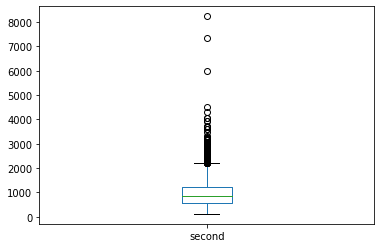

In [11]:
features_data_clean[features_data_clean.second < 600000000].groupby('bookingID').second.max().plot(kind = 'box')
plt.show()

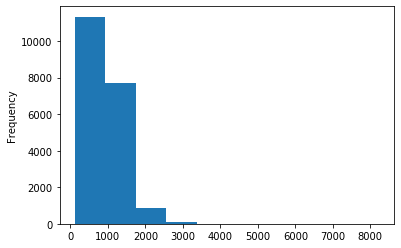

In [12]:
features_data_clean[features_data_clean.second < 600000000].groupby('bookingID').second.max().plot(kind = 'hist')
plt.show()

We can take a closer look at the noises:

In [13]:
features_data_clean[features_data_clean.second >= 600000000].bookingID.value_counts()

858993459333     44
1460288880770    32
1108101562401     3
1434519076976     2
1503238553722     1
Name: bookingID, dtype: int64

In [14]:
features_data_clean[(features_data_clean.bookingID == 858993459333) & (features_data_clean.second >= 800)].sort_values('second').head(20)

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
8636363,858993459333,48.000,352.0,-0.363919,9.586384,0.325611,-0.098349,0.072998,0.074831,803.0,16.573994
8636364,858993459333,13.669,0.0,-1.130063,8.896853,1.273715,-0.060170,0.203724,0.099876,804.0,3.096116
8636365,858993459333,16.000,323.0,0.737414,9.931149,2.566584,0.004581,-0.035125,0.070860,805.0,7.707980
8636366,858993459333,24.000,330.0,-0.708684,9.806650,1.752556,-0.053145,0.204029,0.109039,807.0,9.370184
8636367,858993459333,32.000,332.0,0.814029,9.586384,1.063026,-0.124006,-0.064752,-0.014661,808.0,9.858960
8636368,858993459333,32.000,334.0,0.201113,9.854534,1.254562,-0.007025,0.058643,0.053451,809.0,10.296636
8636369,858993459333,42.542,0.0,0.162806,9.883265,0.861913,0.050702,0.052840,0.054978,619315360.0,-1.000000
8636370,858993459333,33.727,0.0,-0.507571,9.758766,1.350330,-0.055894,0.140804,0.113315,619315371.0,-1.000000
8636371,858993459333,16.491,0.0,0.488417,9.806650,-0.402226,-0.039706,0.034514,0.038790,619315480.0,-1.000000
8636372,858993459333,37.582,0.0,0.220267,9.806650,1.273715,-0.054062,0.022602,0.024129,619315516.0,-1.000000


Most of the speed records are -1 and bearing records are 0. It's quite likely that those observations are noises. <br>
As a result, we will remove them entirely. 

In [15]:
features_data_clean = features_data_clean[features_data_clean.second < 600000000].sort_values(['bookingID', 'second']).reset_index(drop = True) # We still need second column for later calculations, so we don't set it as index
features_data_clean.describe()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
count,1.613548e+07,1.613548e+07,1.613548e+07,1.613548e+07,1.613548e+07,1.613548e+07,1.613548e+07,1.613548e+07,1.613548e+07,1.613548e+07,1.613548e+07
mean,8.184803e+11,1.161032e+01,1.689692e+02,6.914402e-02,4.468950e+00,8.942965e-01,-1.710644e-03,2.800557e-04,-2.570650e-04,6.018402e+02,9.006594e+00
std,4.952479e+11,8.691693e+01,1.072962e+02,1.424165e+00,8.130676e+00,3.251556e+00,1.445622e-01,3.400635e-01,1.480827e-01,4.628707e+02,8.106404e+00
min,0.000000e+00,7.500000e-01,0.000000e+00,-7.841969e+01,-7.299412e+01,-7.844842e+01,-4.845575e+01,-7.488861e+01,-5.355445e+01,0.000000e+00,-2.000000e+00
25%,3.779571e+11,3.900000e+00,7.800000e+01,-5.081238e-01,-2.023074e+00,-9.316101e-01,-2.678827e-02,-2.993851e-02,-1.876517e-02,2.410000e+02,1.020000e+00
50%,8.074539e+11,4.249000e+00,1.688738e+02,6.135559e-02,9.081485e+00,7.757450e-01,-6.432411e-04,2.645046e-04,-3.543019e-05,5.200000e+02,7.530000e+00
75%,1.254130e+12,8.000000e+00,2.629864e+02,6.350620e-01,9.709767e+00,2.750938e+00,2.330665e-02,3.143070e-02,1.823425e-02,8.630000e+02,1.548000e+01
max,1.709397e+12,6.070101e+03,3.599995e+02,6.687346e+01,7.505589e+01,7.805576e+01,3.983975e+01,8.031496e+01,6.630078e+01,8.235000e+03,1.480186e+02


Another strange figure is maximum accuracy. <br>
While the 75th quantile is 8, the maximum value is 6000 <br>
Again, we take a close look at the distribution of accuracy.

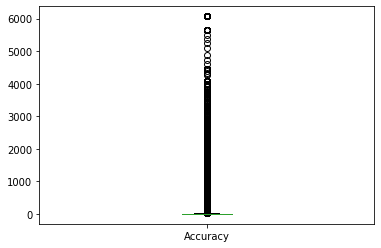

In [16]:
features_data_clean.Accuracy.plot(kind = 'box')
plt.show()

Distribution for those below 50:

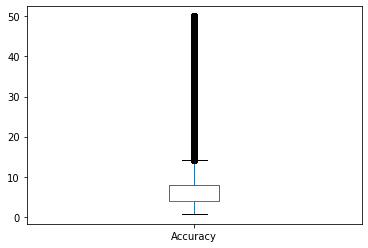

In [17]:
features_data_clean[features_data_clean.Accuracy <= 50].Accuracy.plot(kind = 'box')
plt.show()

Extract the rows whose accuracy is more than 50:

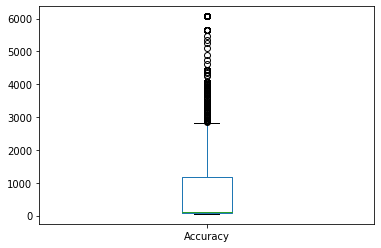

In [18]:
features_data_clean[features_data_clean.Accuracy > 50].Accuracy.plot(kind = 'box')

It seems that accuracy typically ranges from 0 to around 15, but there exists observations up to thousands. <br>
We will try taking a closer look at observations with more than 1000 accuracy. <br>
We observe a pattern: speed tends to equal -1.

In [19]:
features_data_clean[features_data_clean.Accuracy > 1000].head()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
7232,13,1251.564,0.00000,1.393468,7.743085,3.720703,-0.031536,-0.101730,0.040272,1147.0,-1.0
7233,13,1065.085,0.00000,1.819649,10.659311,5.066286,0.024053,0.037547,-0.015928,1152.0,-1.0
13829,28,1027.026,0.00000,0.747014,9.976943,1.055875,0.051422,-0.044145,-0.008329,782.0,-1.0
13830,28,1375.983,0.00000,-0.428575,9.778218,2.061470,0.021490,0.027326,-0.038872,826.0,-1.0
38648,82,1128.000,14.64523,-0.644202,-8.336938,-1.870996,-0.103289,-0.073559,-0.120129,93.0,-1.0


Instead of using value_counts(), we could plot a scatter plot to see the pattern of high accuracy. <br>
Like abnormally-high-second observations, we can see that abnormally-high-accuracy observations tend to have speed of -1, as above around 500 accuracy, the scatter plot is roughly a horizontal line at -1 speed.

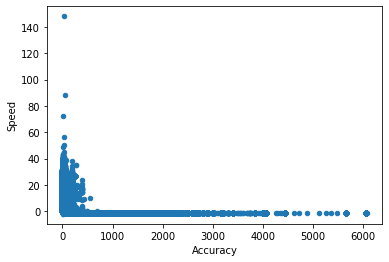

In [20]:
features_data_clean.plot.scatter('Accuracy', 'Speed')
plt.show()

I suspect abnormally-high accuracy occurs when the trip ends. <br>
We can use visualization to confirm this hypothesis. <br>
Consequentially, the hypothesis is wrong. Most of the observations recorded at trip end have reasonable accuracy.

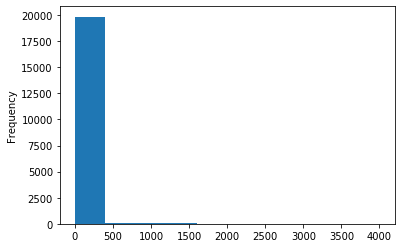

In [21]:
trip_end_record = features_data_clean.groupby('bookingID').second.idxmax()
trip_end_obs = features_data_clean.loc[trip_end_record, ]
trip_end_obs.Accuracy.plot(kind = 'hist')

We may take a look at how accuracy changes during a trip. <br>
As the plot below shows, abnormally-high-accuracy points are in the middle of the trip, and tend to group together. <br>
Hence, I don't think this is a random noise. Instead, it's a signal of an important event, say when the car enters a tunel. <br>
As a result, we will keep this in mind, and use them later as our feature.

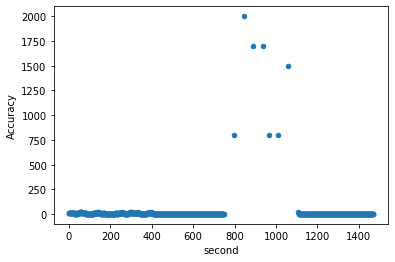

In [22]:
features_data_clean[features_data_clean.bookingID == 17179869259].plot.scatter('second', 'Accuracy')

Lastly, we look at rows where speed is negative. <br>
As a distribution below indicates, there is a abnormally huge amount of (-1) values. <br>
(-1) speed seems to indicate missing values or similar events.

In [23]:
features_data_clean[features_data_clean.Speed <0].Speed.value_counts().head()

-1.000000    237176
-0.010511         1
-0.079760         1
-0.159249         1
-0.213707         1
Name: Speed, dtype: int64

We look into the summary statistics of rows where speed is negative, and compare with summary statistics of other observations. <br>
The results are shown below. Except for accuracy (which we already discussed above), the other features don't behave so abnormally. Hence, we should not remove these rows entirely.

In [24]:
features_data_clean[features_data_clean.Speed < 0].describe()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
count,2.403060e+05,240306.000000,240306.000000,240306.000000,240306.000000,240306.000000,240306.000000,240306.000000,240306.000000,240306.000000,240306.000000
mean,8.217519e+11,335.363685,121.036962,0.089208,-1.891245,-0.988901,-0.003733,-0.000823,-0.002157,673.728043,-0.988232
std,5.037520e+11,630.207921,116.590712,2.270806,8.342445,4.514055,0.331900,0.382645,0.380036,539.268708,0.102968
min,0.000000e+00,3.000000,0.000000,-67.893442,-45.858246,-72.962119,-17.590496,-16.359860,-25.792377,0.000000,-2.000000
25%,3.693672e+11,21.079250,0.000000,-0.581809,-9.450684,-3.364862,-0.039456,-0.042785,-0.026269,250.000000,-1.000000
50%,8.160438e+11,65.000000,90.155193,0.050262,-5.846489,-0.654814,-0.002466,0.000185,-0.000046,569.000000,-1.000000
75%,1.262720e+12,124.745750,219.329742,0.720645,8.630091,1.453641,0.030574,0.043140,0.024948,986.000000,-1.000000
max,1.709397e+12,6070.101000,359.996338,58.813757,48.005884,49.063590,30.709417,32.601880,27.377758,5199.000000,-0.000024


In [25]:
features_data_clean[features_data_clean.Speed >= 0].describe()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
count,1.589517e+07,1.589517e+07,1.589517e+07,1.589517e+07,1.589517e+07,1.589517e+07,1.589517e+07,1.589517e+07,1.589517e+07,1.589517e+07,1.589517e+07
mean,8.184308e+11,6.715756e+00,1.696939e+02,6.884068e-02,4.565105e+00,9.227670e-01,-1.680077e-03,2.967379e-04,-2.283364e-04,6.007534e+02,9.157698e+00
std,4.951181e+11,7.472429e+00,1.069848e+02,1.407460e+00,8.089150e+00,3.220244e+00,1.398167e-01,3.393787e-01,1.416915e-01,4.615328e+02,8.073043e+00
min,0.000000e+00,7.500000e-01,0.000000e+00,-7.841969e+01,-7.299412e+01,-7.844842e+01,-4.845575e+01,-7.488861e+01,-5.355445e+01,0.000000e+00,0.000000e+00
25%,3.779571e+11,3.900000e+00,7.900000e+01,-5.075707e-01,-6.663330e-01,-9.050358e-01,-2.663373e-02,-2.982741e-02,-1.865757e-02,2.410000e+02,1.262630e+00
50%,8.074539e+11,4.029000e+00,1.690000e+02,6.164551e-02,9.098000e+00,7.944183e-01,-6.256104e-04,2.663161e-04,-3.490659e-05,5.190000e+02,7.760000e+00
75%,1.254130e+12,8.000000e+00,2.630000e+02,6.344818e-01,9.713572e+00,2.763733e+00,2.321589e-02,3.123721e-02,1.815142e-02,8.610000e+02,1.560737e+01
max,1.709397e+12,6.999990e+02,3.599995e+02,6.687346e+01,7.505589e+01,7.805576e+01,3.983975e+01,8.031496e+01,6.630078e+01,8.235000e+03,1.480186e+02


Alternatively, we can check which observations tend to observe negative speed. <br>
As the table below show, negative speed tends to gather where accuracy equals 65. <br>
A quick Internet search suggests that, 65 is accuracy of WiFi, while 1414 is accuracy of cell tower.

In [26]:
features_data_clean[features_data_clean.Speed < 0].Accuracy.value_counts().head()

65.0      50797
1414.0    24540
48.0      14833
3.0        6440
165.0      5283
Name: Accuracy, dtype: int64

There are a lot of ways to impute these negative speed. <br>
Should we make them zero? Or should we remove them entirely? <br>
First, we check whether negative speed correlates with our label, i.e. with the danger/safety of a trip.

In [27]:
no_of_trips_w_negative_speed = features_data_clean.groupby('bookingID').Speed.apply(lambda x: (x < 0).sum())
no_of_trips_w_negative_speed[no_of_trips_w_negative_speed > 0].head()

bookingID
0      1
1     13
8      2
13     6
14     2
Name: Speed, dtype: int64

As we can see in the scatter plot below, having lots of negative speed records don't really correlate with safe trip or dangerous trip, maybe except extreme cases. <br>
Hence, imputing them doesn't lose much information.

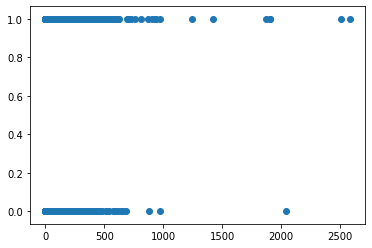

In [28]:
plt.scatter(no_of_trips_w_negative_speed, labels_data_clean.label)

We do the same for the percentage of negative speed records out of all records in a trip. <br>
Likewise, the percentage of negative speed doesn't seem to correlate with safety/danger.

In [29]:
no_of_trips_w_positive_speed = features_data_clean.groupby('bookingID').Speed.apply(lambda x: (x >= 0).sum())
pct_of_trips_w_negative_speed = (no_of_trips_w_negative_speed) * 100 / (no_of_trips_w_negative_speed + no_of_trips_w_positive_speed)
pct_of_trips_w_negative_speed[pct_of_trips_w_negative_speed > 0].head()

bookingID
0     0.099602
1     1.527615
8     0.516796
13    0.488599
14    0.333333
Name: Speed, dtype: float64

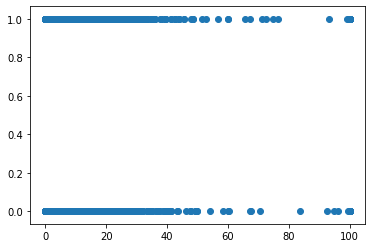

In [30]:
plt.scatter(pct_of_trips_w_negative_speed, labels_data_clean.label)

Consequentiall, instead of making all negative speed zero, we can have a dummy variable to mark them, to avoid losing information. <br>
Hence, we will make positive_speed dummy variable, which equals 1 if speed is positive, and 0 otherwise. <br>
In case we need to make negative speed zero, we can multiply this dummy variable with speed.

In [31]:
features_data_clean['positive_speed'] = [1 if speed >= 0 else 0 for speed in features_data_clean.Speed]
features_data_clean.describe()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,positive_speed
count,1.613548e+07,1.613548e+07,1.613548e+07,1.613548e+07,1.613548e+07,1.613548e+07,1.613548e+07,1.613548e+07,1.613548e+07,1.613548e+07,1.613548e+07,1.613548e+07
mean,8.184803e+11,1.161032e+01,1.689692e+02,6.914402e-02,4.468950e+00,8.942965e-01,-1.710644e-03,2.800557e-04,-2.570650e-04,6.018402e+02,9.006594e+00,9.851070e-01
std,4.952479e+11,8.691693e+01,1.072962e+02,1.424165e+00,8.130676e+00,3.251556e+00,1.445622e-01,3.400635e-01,1.480827e-01,4.628707e+02,8.106404e+00,1.211248e-01
min,0.000000e+00,7.500000e-01,0.000000e+00,-7.841969e+01,-7.299412e+01,-7.844842e+01,-4.845575e+01,-7.488861e+01,-5.355445e+01,0.000000e+00,-2.000000e+00,0.000000e+00
25%,3.779571e+11,3.900000e+00,7.800000e+01,-5.081238e-01,-2.023074e+00,-9.316101e-01,-2.678827e-02,-2.993851e-02,-1.876517e-02,2.410000e+02,1.020000e+00,1.000000e+00
50%,8.074539e+11,4.249000e+00,1.688738e+02,6.135559e-02,9.081485e+00,7.757450e-01,-6.432411e-04,2.645046e-04,-3.543019e-05,5.200000e+02,7.530000e+00,1.000000e+00
75%,1.254130e+12,8.000000e+00,2.629864e+02,6.350620e-01,9.709767e+00,2.750938e+00,2.330665e-02,3.143070e-02,1.823425e-02,8.630000e+02,1.548000e+01,1.000000e+00
max,1.709397e+12,6.070101e+03,3.599995e+02,6.687346e+01,7.505589e+01,7.805576e+01,3.983975e+01,8.031496e+01,6.630078e+01,8.235000e+03,1.480186e+02,1.000000e+00


#### 2.2.2. Unequal interval between timestamps:

For most of our observations, the timestamps are 1 second apart. <br>
In this part, we will check for unequal interval, where the time interval between 2 records is more than 1 second. <br>

In [32]:
time_interval = features_data_clean.second.diff() # Calculate time interval between 2 contiguous records
time_interval[features_data_clean.second == 0] = -999 # When second is 0 (start of a trip), don't need to calculate time interval
time_interval.value_counts().head(10)

 1.0      15805648
 2.0        259195
-999.0       20000
 5.0         14898
 3.0          5980
 6.0          3844
 4.0          2913
 10.0         2552
 7.0          1531
 11.0         1193
Name: second, dtype: int64

In [33]:
time_interval_dist = time_interval.groupby(features_data_clean.bookingID).max().value_counts()
time_interval_dist.head(10)

1.0      4972
2.0      4605
3.0       863
4.0       378
16.0      362
46.0      307
5.0       198
31.0      158
241.0     151
196.0     145
Name: second, dtype: int64

We plot the frequency of max time interval each trip observes in a histogram. <br>
Notably, we filter out 2 outliers, which are larger than 1000 seconds, to make the graph more concise.

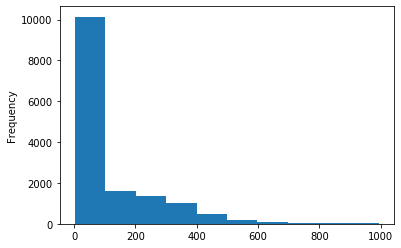

In [34]:
time_interval[(time_interval > 1) & (time_interval < 1000)].groupby(features_data_clean.bookingID).max().plot.hist()

We take a look at the observations where there is a huge jump in timestamp. <br>
Now, we can try where the jump is more than 100 seconds.

In [35]:
missing_timestamps_following_idx = features_data_clean.index[(features_data_clean.second != 0) & (features_data_clean.second.diff() != 1) & (features_data_clean.second.diff() >= 100)]
missing_timestamps_surrounding_idx = [x + step for x in missing_timestamps_following_idx for step in [-1,0,1]]
features_data_clean.loc[missing_timestamps_surrounding_idx,].head(15)

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,positive_speed
314,0,16.000,238.402939,-0.331223,-9.722391,-2.078403,0.031664,0.022209,-0.004149,314.0,0.162426,1
315,0,16.000,310.203186,-0.085086,-9.926208,-1.731479,-0.022061,-0.028461,0.021524,900.0,0.903141,1
316,0,16.000,310.203186,-0.952246,-9.372028,-1.629645,-0.003132,0.012168,-0.026764,901.0,0.064309,1
1123,1,3.000,307.000000,-0.689204,9.693683,-2.232775,0.000506,-0.003281,-0.001536,119.0,0.000000,1
1124,1,3.000,298.000000,-0.288358,9.391601,-2.000107,0.007802,-0.011222,0.006964,300.0,0.000000,1
1125,1,3.000,0.000000,-0.181950,9.219496,-3.406393,0.006632,-0.100217,0.036704,301.0,-1.000000,0
1974,2,3.601,216.000000,0.069434,9.634562,1.376708,-0.013497,-0.010571,0.023755,119.0,0.338589,1
1975,2,3.000,288.000000,0.462095,9.617802,0.761379,0.024377,0.008977,0.010927,750.0,0.000000,1
1976,2,3.000,288.000000,0.378295,9.845258,-0.004789,0.002385,0.009588,-0.002512,751.0,0.000000,1
10909,25,6.806,258.000000,-0.766145,9.404425,1.359907,-0.007871,0.000541,0.033790,149.0,2.153941,1


It's strange that there are sometimes huge jumps in time interval. <br>
Below, we will check the change in bearing in huge time intervals, and compare them with those of 1-second interval. <br>

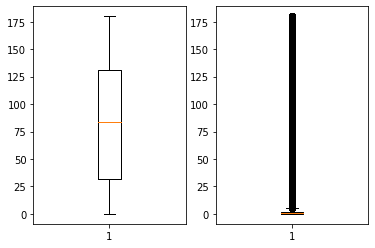

In [36]:
bearing_change_clockwise = abs(features_data_clean.Bearing.diff())
bearing_change_anticlockwise = 360 - abs(features_data_clean.Bearing.diff())                                
bearing_change = np.where(bearing_change_clockwise <= bearing_change_anticlockwise, bearing_change_clockwise, bearing_change_anticlockwise)                                

bearing_change[features_data_clean.second == 0] = 0
bearing_change[time_interval >= 100]
del bearing_change_clockwise, bearing_change_anticlockwise

plt.subplot(1, 2, 1)
plt.boxplot(bearing_change[time_interval >= 100])
plt.subplot(1, 2, 2)
plt.boxplot(bearing_change[time_interval < 100])
del bearing_change
plt.show()

As we see a significant difference in bearing change between 1-second interval and huge interval, we can assume there are indeed huge time intervals between data points. <br>
Because the time stamp is not continuous anyway (at first, I tend to avoid removing data points inbetween a trip), we could remove outliers, especially outliers in speed values.
For speed, the filter value is 40 m/s, which is reasonable as a maximum speed without losing much data. <br>
For accurcy, filter value of 1500 is to retain information from 1414 accuracy, which is the accuracy of cell tower.

{'whiskers': [<matplotlib.lines.Line2D at 0x5c02f19710>,
 'caps': [<matplotlib.lines.Line2D at 0x5c02f19e10>,
 'boxes': [<matplotlib.lines.Line2D at 0x5c02f192e8>],
 'medians': [<matplotlib.lines.Line2D at 0x5c03fd24e0>],
 'fliers': [<matplotlib.lines.Line2D at 0x5c03fd2828>],
 'means': []}

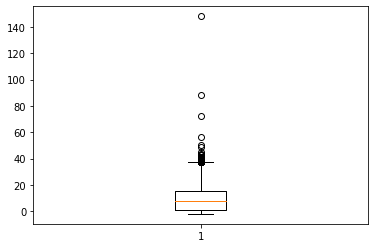

In [37]:
plt.boxplot(features_data_clean.Speed)

In [38]:
features_data_clean = features_data_clean[features_data_clean.Speed <= 40].sort_values(['bookingID', 'second']).reset_index(drop = True) 
features_data_clean = features_data_clean[features_data_clean.Accuracy <= 1500].sort_values(['bookingID', 'second']).reset_index(drop = True) 
features_data_clean.describe()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,positive_speed
count,1.612509e+07,1.612509e+07,1.612509e+07,1.612509e+07,1.612509e+07,1.612509e+07,1.612509e+07,1.612509e+07,1.612509e+07,1.612509e+07,1.612509e+07,1.612509e+07
mean,8.184891e+11,1.015762e+01,1.689837e+02,6.929044e-02,4.475818e+00,8.958545e-01,-1.706237e-03,2.769416e-04,-2.602900e-04,6.016183e+02,9.012952e+00,9.857400e-01
std,4.952503e+11,6.263297e+01,1.072909e+02,1.423098e+00,8.127110e+00,3.251222e+00,1.444626e-01,3.400232e-01,1.479799e-01,4.627706e+02,8.104815e+00,1.185606e-01
min,0.000000e+00,7.500000e-01,0.000000e+00,-7.841969e+01,-7.299412e+01,-7.844842e+01,-4.845575e+01,-7.488861e+01,-5.355445e+01,0.000000e+00,-2.000000e+00,0.000000e+00
25%,3.779571e+11,3.900000e+00,7.800000e+01,-5.079730e-01,-1.896268e+00,-9.304047e-01,-2.677436e-02,-2.993240e-02,-1.876229e-02,2.410000e+02,1.030000e+00,1.000000e+00
50%,8.074539e+11,4.237000e+00,1.689033e+02,6.145935e-02,9.082938e+00,7.769897e-01,-6.410229e-04,2.632829e-04,-3.543019e-05,5.200000e+02,7.540000e+00,1.000000e+00
75%,1.254130e+12,8.000000e+00,2.630000e+02,6.350760e-01,9.710283e+00,2.751789e+00,2.330017e-02,3.141595e-02,1.822883e-02,8.620000e+02,1.548645e+01,1.000000e+00
max,1.709397e+12,1.500000e+03,3.599995e+02,6.687346e+01,7.505589e+01,7.805576e+01,3.983975e+01,8.031496e+01,6.630078e+01,8.235000e+03,3.997902e+01,1.000000e+00


#### 2.2.3. Check for missing values:

We don't have missing values, as indicated below.

In [39]:
features_data_clean.isnull().sum()

bookingID         0
Accuracy          0
Bearing           0
acceleration_x    0
acceleration_y    0
acceleration_z    0
gyro_x            0
gyro_y            0
gyro_z            0
second            0
Speed             0
positive_speed    0
dtype: int64

## 3. Sequential Learning:

### 3.1. Feature Engineering:

We will start by making new features for our sequential model. <br>
Notable features include: histograms and percentiles over speeds, accelerations, angles, speed * angles, accelerations over accelerations, speeds and accelerations over larger windows. <br>
First, just impute negative speeds to be zero.

In [40]:
features_data_clean.head()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,positive_speed
0,0,12.0,143.298294,0.818112,-9.941461,-2.014999,-0.016245,-0.094040,0.070732,0.0,3.442991,1
1,0,8.0,143.298294,0.546405,-9.835590,-2.038925,-0.047092,-0.078874,0.043187,1.0,0.228454,1
2,0,8.0,143.298294,-1.706207,-9.270792,-1.209448,-0.028965,-0.032652,0.015390,2.0,0.228454,1
3,0,8.0,143.298294,-1.416705,-9.548032,-1.860977,-0.022413,0.005049,-0.025753,3.0,0.228454,1
4,0,8.0,143.298294,-0.598145,-9.853534,-1.378574,-0.014297,-0.046206,0.021902,4.0,0.228454,1


In [41]:
features_data_sequential = features_data_clean.copy()
features_data_sequential['imputed_speed'] = features_data_sequential.Speed * features_data_sequential.positive_speed
del features_data_clean
features_data_sequential.head()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,positive_speed,imputed_speed
0,0,12.0,143.298294,0.818112,-9.941461,-2.014999,-0.016245,-0.094040,0.070732,0.0,3.442991,1,3.442991
1,0,8.0,143.298294,0.546405,-9.835590,-2.038925,-0.047092,-0.078874,0.043187,1.0,0.228454,1,0.228454
2,0,8.0,143.298294,-1.706207,-9.270792,-1.209448,-0.028965,-0.032652,0.015390,2.0,0.228454,1,0.228454
3,0,8.0,143.298294,-1.416705,-9.548032,-1.860977,-0.022413,0.005049,-0.025753,3.0,0.228454,1,0.228454
4,0,8.0,143.298294,-0.598145,-9.853534,-1.378574,-0.014297,-0.046206,0.021902,4.0,0.228454,1,0.228454


Then, we can look at the 3 acceleration columns. <br>
As acceleration_y is more concentrated around 10 m/s2, it seems that y-axis is the vertical axis that bears gravitational forces. <br>
However, as the car/phone won't always be parallel to the ground, we won't adjust for gravitational force.

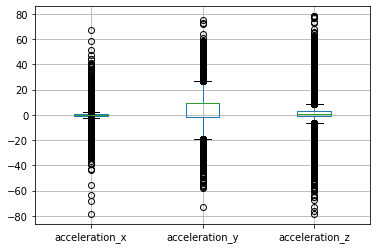

In [42]:
features_data_sequential[['acceleration_x', 'acceleration_y', 'acceleration_z']].boxplot()
plt.show()

A feature that can be extracted is the total acceleration and total gyro.

In [43]:
features_data_sequential['acceleration_total'] = (features_data_sequential.acceleration_x ** 2 +\
                                                  features_data_sequential.acceleration_y ** 2 +\
                                                  features_data_sequential.acceleration_z ** 2) **0.5

features_data_sequential['gyro_total'] = (features_data_sequential.gyro_x ** 2 +\
                                          features_data_sequential.gyro_y ** 2 +\
                                          features_data_sequential.gyro_z ** 2) **0.5

features_data_sequential[['acceleration_x', 'acceleration_y', 'acceleration_z', 'acceleration_total']].head()

,acceleration_x,acceleration_y,acceleration_z,acceleration_total
0,0.818112,-9.941461,-2.014999,10.176551
1,0.546405,-9.835590,-2.038925,10.059553
2,-1.706207,-9.270792,-1.209448,9.503762
3,-1.416705,-9.548032,-1.860977,9.830320
4,-0.598145,-9.853534,-1.378574,9.967466


The next feature is the moving average of acceleration, gyro, and speed. <br>
It is noteworthy that our time intervals are uneven, so computing rolling meaan needs to be time-aware. <br>
Because cumsum() method is rather slow as the data gets larger, we will do a bit work-around by adding an origin point of time, 01/01/2018, to our data.

In [44]:
def make_timestamp (second):
    return pd.Timestamp('2018-01-01') + datetime.timedelta(seconds = second)

features_data_sequential['timestamp'] = features_data_sequential.second.apply(make_timestamp)
features_data_sequential

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed,positive_speed,imputed_speed,acceleration_total,gyro_total,timestamp
0,0,12.0,143.298294,0.818112,-9.941461,-2.014999,-0.016245,-0.094040,0.070732,0.0,3.442991,1,3.442991,10.176551,0.118788,2018-01-01 00:00:00
1,0,8.0,143.298294,0.546405,-9.835590,-2.038925,-0.047092,-0.078874,0.043187,1.0,0.228454,1,0.228454,10.059553,0.101508,2018-01-01 00:00:01
2,0,8.0,143.298294,-1.706207,-9.270792,-1.209448,-0.028965,-0.032652,0.015390,2.0,0.228454,1,0.228454,9.503762,0.046282,2018-01-01 00:00:02
3,0,8.0,143.298294,-1.416705,-9.548032,-1.860977,-0.022413,0.005049,-0.025753,3.0,0.228454,1,0.228454,9.830320,0.034511,2018-01-01 00:00:03
4,0,8.0,143.298294,-0.598145,-9.853534,-1.378574,-0.014297,-0.046206,0.021902,4.0,0.228454,1,0.228454,9.967466,0.053095,2018-01-01 00:00:04
5,0,8.0,143.298294,-0.608313,-9.539658,-1.794583,-0.007538,-0.023838,0.018068,5.0,0.228454,1,0.228454,9.726029,0.030847,2018-01-01 00:00:05
6,0,8.0,143.298294,-0.867758,-9.698615,-1.615439,0.022728,-0.012178,0.005982,6.0,0.228454,1,0.228454,9.870449,0.026470,2018-01-01 00:00:06
7,0,8.0,143.298294,-1.050790,-9.745270,-1.411771,0.027603,0.001841,0.000904,7.0,0.228454,1,0.228454,9.902906,0.027680,2018-01-01 00:00:07
8,0,8.0,143.298294,-0.721213,-9.960004,-1.202271,0.001864,-0.007702,0.014018,8.0,0.228454,1,0.228454,10.058194,0.016103,2018-01-01 00:00:08
9,0,8.0,143.298294,-0.346924,-9.532629,-1.204663,0.014962,-0.050033,0.025118,9.0,0.228454,1,0.228454,9.614707,0.057949,2018-01-01 00:00:09


In [45]:
id_group = features_data_sequential.groupby('bookingID').rolling('30s', on = 'timestamp', min_periods = 1)
features_data_sequential['rolling_acc_x'] = id_group.acceleration_x.mean().reset_index(drop=True)
features_data_sequential['rolling_acc_y'] = id_group.acceleration_y.mean().reset_index(drop=True)
features_data_sequential['rolling_acc_z'] = id_group.acceleration_z.mean().reset_index(drop=True)
features_data_sequential['rolling_acc_total'] = id_group.acceleration_total.mean().reset_index(drop=True)
features_data_sequential['rolling_gyro_x'] = id_group.gyro_x.mean().reset_index(drop=True)
features_data_sequential['rolling_gyro_y'] = id_group.gyro_y.mean().reset_index(drop=True)
features_data_sequential['rolling_gyro_z'] = id_group.gyro_z.mean().reset_index(drop=True)
features_data_sequential['rolling_gyro_total'] = id_group.gyro_total.mean().reset_index(drop=True)
features_data_sequential['rolling_speed'] = id_group.imputed_speed.mean().reset_index(drop=True)
del id_group
features_data_sequential.head()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,...,timestamp,rolling_acc_x,rolling_acc_y,rolling_acc_z,rolling_acc_total,rolling_gyro_x,rolling_gyro_y,rolling_gyro_z,rolling_gyro_total,rolling_speed
0,0,12.0,143.298294,0.818112,-9.941461,-2.014999,-0.016245,-0.094040,0.070732,0.0,...,2018-01-01 00:00:00,0.818112,-9.941461,-2.014999,10.176551,-0.016245,-0.094040,0.070732,0.118788,3.442991
1,0,8.0,143.298294,0.546405,-9.835590,-2.038925,-0.047092,-0.078874,0.043187,1.0,...,2018-01-01 00:00:01,0.682259,-9.888525,-2.026962,10.118052,-0.031668,-0.086457,0.056960,0.110148,1.835723
2,0,8.0,143.298294,-1.706207,-9.270792,-1.209448,-0.028965,-0.032652,0.015390,2.0,...,2018-01-01 00:00:02,-0.113897,-9.682614,-1.754458,9.913288,-0.030767,-0.068522,0.043103,0.088859,1.299966
3,0,8.0,143.298294,-1.416705,-9.548032,-1.860977,-0.022413,0.005049,-0.025753,3.0,...,2018-01-01 00:00:03,-0.439599,-9.648969,-1.781087,9.892546,-0.028679,-0.050130,0.025889,0.075272,1.032088
4,0,8.0,143.298294,-0.598145,-9.853534,-1.378574,-0.014297,-0.046206,0.021902,4.0,...,2018-01-01 00:00:04,-0.471308,-9.689882,-1.700585,9.907530,-0.025802,-0.049345,0.025092,0.070837,0.871362


We can also look at the change in bearing. <br>
Specifically, GPS bearing is the degree of drivers deviated from the north. <br>
Hence, change in bearing helps to indicate the rotational movement of drivers. <br>
It is noteworthy it is assumed, the driver takes the SHORTEST way to rotate. In other words, the change in bearing should always be below 180 degree.

In [46]:
bearing_change_clockwise = abs(features_data_sequential.Bearing.diff()) / features_data_sequential.second.diff()
bearing_change_anticlockwise = (360 - abs(features_data_sequential.Bearing.diff())) / features_data_sequential.second.diff()
features_data_sequential['bearing_change'] = np.where(bearing_change_clockwise <= bearing_change_anticlockwise, bearing_change_clockwise, bearing_change_anticlockwise)
features_data_sequential.loc[features_data_sequential.second == 0, 'bearing_change'] = 0
del bearing_change_clockwise, bearing_change_anticlockwise

features_data_sequential['rolling_bearing_change'] = features_data_sequential.groupby('bookingID').rolling('30s', on = 'timestamp', min_periods = 1).bearing_change.mean().reset_index(drop=True)
features_data_sequential.describe()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,...,rolling_acc_y,rolling_acc_z,rolling_acc_total,rolling_gyro_x,rolling_gyro_y,rolling_gyro_z,rolling_gyro_total,rolling_speed,bearing_change,rolling_bearing_change
count,1.612509e+07,1.612509e+07,1.612509e+07,1.612509e+07,1.612509e+07,1.612509e+07,1.612509e+07,1.612509e+07,1.612509e+07,1.612509e+07,...,1.612509e+07,1.612509e+07,1.612509e+07,1.612509e+07,1.612509e+07,1.612509e+07,1.612509e+07,1.612509e+07,1.612509e+07,1.612509e+07
mean,8.184891e+11,1.015762e+01,1.689837e+02,6.929044e-02,4.475818e+00,8.958545e-01,-1.706237e-03,2.769416e-04,-2.602900e-04,6.016183e+02,...,4.475104e+00,8.960603e-01,9.892825e+00,-1.691376e-03,2.644901e-04,-2.622469e-04,1.290638e-01,8.974519e+00,3.308861e+00,3.299108e+00
std,4.952503e+11,6.263297e+01,1.072909e+02,1.423098e+00,8.127110e+00,3.251222e+00,1.444626e-01,3.400232e-01,1.479799e-01,4.627706e+02,...,8.081856e+00,3.053538e+00,9.820783e-01,3.917706e-02,2.400623e-01,4.955726e-02,2.892512e-01,7.604853e+00,1.242166e+01,4.763131e+00
min,0.000000e+00,7.500000e-01,0.000000e+00,-7.841969e+01,-7.299412e+01,-7.844842e+01,-4.845575e+01,-7.488861e+01,-5.355445e+01,0.000000e+00,...,-1.633239e+01,-3.419927e+01,2.303503e-02,-5.290239e+00,-2.127908e+01,-8.465109e+00,0.000000e+00,-1.886491e-12,-2.891667e+00,-2.891667e+00
25%,3.779571e+11,3.900000e+00,7.800000e+01,-5.079730e-01,-1.896268e+00,-9.304047e-01,-2.677436e-02,-2.993240e-02,-1.876229e-02,2.410000e+02,...,-1.786380e+00,-7.529994e-01,9.741869e+00,-9.702865e-03,-1.542462e-02,-7.221476e-03,4.858570e-02,2.373706e+00,0.000000e+00,5.000000e-01
50%,8.074539e+11,4.237000e+00,1.689033e+02,6.145935e-02,9.082938e+00,7.769897e-01,-6.410229e-04,2.632829e-04,-3.543019e-05,5.200000e+02,...,9.271749e+00,7.623371e-01,9.848936e+00,-5.939938e-04,2.382863e-04,-9.325881e-05,9.618853e-02,7.160701e+00,4.910049e-01,1.533333e+00
75%,1.254130e+12,8.000000e+00,2.630000e+02,6.350760e-01,9.710283e+00,2.751789e+00,2.330017e-02,3.141595e-02,1.822883e-02,8.620000e+02,...,9.675442e+00,2.614853e+00,9.971919e+00,6.637663e-03,1.669210e-02,6.661340e-03,1.496011e-01,1.456753e+01,2.000000e+00,4.233333e+00
max,1.709397e+12,1.500000e+03,3.599995e+02,6.687346e+01,7.505589e+01,7.805576e+01,3.983975e+01,8.031496e+01,6.630078e+01,8.235000e+03,...,4.373372e+01,4.139276e+01,4.517439e+01,1.537914e+01,3.105997e+01,1.367788e+01,3.387252e+01,3.896190e+01,1.800000e+02,1.400107e+02


Taking a closer look at bearing, as below, we can see mean, median, 25th percentile, 75th percentile are close to 0, as drivers would go straight most of the time. <br>
Then, we could based on change to bearing to find whether the driver is turning left/right.

In [47]:
features_data_sequential.bearing_change.describe()

count    1.612509e+07
mean     3.308861e+00
std      1.242166e+01
min     -2.891667e+00
25%      0.000000e+00
50%      4.910049e-01
75%      2.000000e+00
max      1.800000e+02
Name: bearing_change, dtype: float64

If high bearing change means turning, we can make a dummy variable to indicate speed during turning. <br>
The turning indicator variable will be 1 if the car is turning, and 0 otherwise. <br>
Then, we define that, speed during turning, which is also interaction between speed and turning dummy, will be 0 when the car is going straight, and equal the speed if the car is turning. The feature is to capture whether the driver is being careless when he makes a turn to the left/right. <br>
However, the main problem here is that, we don't have a clear cut-off point to indicate turning dummy variable. Is the change in bearing more than 30 degree indicates turning, or should it be more than 90 degree? <br>
In that case, we can make the turning indicator continuous instead: The farther the bearing change from zero, the more likely the car is turning.

In [48]:
turning_indicator = features_data_sequential.bearing_change / features_data_sequential.bearing_change.max()
features_data_sequential['speed_during_turning'] = turning_indicator * features_data_sequential.imputed_speed
del turning_indicator

turning_indicator_x = abs(features_data_sequential.gyro_x) / abs(features_data_sequential.gyro_x).max()
features_data_sequential['speed_during_turning_x'] = turning_indicator_x * features_data_sequential.imputed_speed

turning_indicator_y = abs(features_data_sequential.gyro_y) / abs(features_data_sequential.gyro_y).max()
features_data_sequential['speed_during_turning_y'] = turning_indicator_y * features_data_sequential.imputed_speed

turning_indicator_z = abs(features_data_sequential.gyro_z) / abs(features_data_sequential.gyro_z).max()
features_data_sequential['speed_during_turning_z'] = turning_indicator_z * features_data_sequential.imputed_speed
del turning_indicator_x, turning_indicator_y, turning_indicator_z

Next, we can calculate the change in speed and change in acceleration. <br>
Change in speed can be based on percentage change, while change in acceleration is in raw change. <br>
Notably, as we can't calculate percentage change from zero, we will add all speed with the min speed, and calculate the percentage change of the resulted series. 

In [49]:
# As there are zero speed, where percentage change can't be computed, we add all speed values with the mean speed.
min_speed = features_data_sequential.imputed_speed[features_data_sequential.imputed_speed != 0].min()
features_data_sequential['speed_pct_change'] = (features_data_sequential.imputed_speed + min_speed).pct_change() / features_data_sequential.second.diff()
features_data_sequential.loc[features_data_sequential.second == 0, 'speed_pct_change'] = 0
del min_speed

# Raw changeof acceleration:
features_data_sequential['accel_x_raw_change'] = features_data_sequential.acceleration_x.diff() / features_data_sequential.second.diff()
features_data_sequential.loc[features_data_sequential.second == 0, 'accel_x_raw_change'] = 0
features_data_sequential['accel_y_raw_change'] = features_data_sequential.acceleration_y.diff() / features_data_sequential.second.diff()
features_data_sequential.loc[features_data_sequential.second == 0, 'accel_y_raw_change'] = 0
features_data_sequential['accel_z_raw_change'] = features_data_sequential.acceleration_z.diff() / features_data_sequential.second.diff()
features_data_sequential.loc[features_data_sequential.second == 0, 'accel_z_raw_change'] = 0
features_data_sequential['accel_total_raw_change'] = features_data_sequential.acceleration_total.diff() / features_data_sequential.second.diff()
features_data_sequential.loc[features_data_sequential.second == 0, 'accel_total_raw_change'] = 0
features_data_sequential[['imputed_speed', 'speed_pct_change']].head()

,imputed_speed,speed_pct_change
0,3.442991,0.000000
1,0.228454,-0.933647
2,0.228454,0.000000
3,0.228454,0.000000
4,0.228454,0.000000


As we mention in section 2, accuracy sometimes goes too high. <br>
Hence, we need to account for the time GPS is not reliable as well.

In [50]:
features_data_sequential['high_accuracy'] = np.where(features_data_sequential.Accuracy > 15, 1, 0)

### 3.2. Sequential Model:

The first model we can use is sequential neural network. <br>
Specifically, telematics data typically has a chronological structure to them. For example, a sequence of high speeds might not be as dangerous as a volatile speed sequence. <br>
Sequential models can "remember" the patterns between different observations, and potentially assign labels better.

Import needed libraries:

In [51]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras import regularizers
import keras.metrics
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence

Using TensorFlow backend.


To train our LSTM model, we will use 50 equally-spaced data points in each trip..

In [52]:
n_timestamps = 50

first_obs_index = features_data_sequential.groupby('bookingID').second.idxmin()
last_obs_index = features_data_sequential.groupby('bookingID').second.idxmax()


lstm_sample = []
for idx in features_data_sequential.bookingID.unique():
    temp_array = np.linspace(first_obs_index[idx], last_obs_index[idx], n_timestamps).astype('int')
    lstm_sample.extend(temp_array)
    

features_data_lstm = features_data_sequential.loc[lstm_sample,:].sort_values(['bookingID', 'second']).reset_index(drop=True)
features_data_lstm[['bookingID', 'second']].head(15)

,bookingID,second
0,0,0.0
1,0,20.0
2,0,40.0
3,0,61.0
4,0,81.0
5,0,102.0
6,0,122.0
7,0,143.0
8,0,163.0
9,0,184.0


Process our training data for sequential learning, which includes:
- Sample the data into train data and test data
- Drop non-useful columns
- Scale the data based on z-score normalization
- Reshape the data into 3D arrays (3 dimensions: observation, timestep, feature

In [53]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from random import sample

# Sample the data.
# We cannot use train_test_split, as we have to ensure all observations of the same booking ID belong to the same data partition.
# Hence, we sample on booking ID to make our train and validation sets.
pct_train_split = 0.5
random.seed(7)
train_id = sample(list(np.unique(features_data_lstm.bookingID)), round(pct_train_split*len(np.unique(features_data_lstm.bookingID))))
x_train = features_data_lstm.loc[features_data_lstm.bookingID.isin(train_id),] 
x_valid = features_data_lstm.loc[~(features_data_lstm.bookingID.isin(train_id)),] 
y_train = labels_data_clean.loc[labels_data_clean.index.isin(train_id),] 
y_valid = labels_data_clean.loc[~(labels_data_clean.index.isin(train_id)),] 


# Drop non-useful columns.
not_useful_col = features_data_lstm.columns[features_data_lstm.columns.isin(['second', 'bookingID', 'high_accuracy', 'Accuracy', 'Bearing', 'Speed', 'timestamp', \
                                                      'speed_during_turning_x', 'speed_during_turning_y', 'speed_during_turning_z', 'speed_during_turning', \
                                                      'speed_during_high_accuracy', 'accel_x_raw_change', 'accel_y_raw_change', 'accel_z_raw_change', \
                                                      'acceleration_x', 'acceleration_y', 'acceleration_z', 'gyro_x', 'gyro_y', 'gyro_z'\
                                                      ])]
x_train_dropped = x_train.drop(not_useful_col, 1)
x_valid_dropped = x_valid.drop(not_useful_col, 1)


# Scale data:
scaler = StandardScaler().fit(x_train_dropped)
x_train_scaled = scaler.transform(x_train_dropped)
x_valid_scaled = scaler.transform(x_valid_dropped)


# Reshape into 3D arrays:
# Train data:
n_obs = len(x_train.bookingID.unique())
n_cols = x_train_scaled.shape[1]
x_train_reshaped = np.array(x_train_scaled)
x_train_reshaped = x_train_reshaped.reshape(n_obs, n_timestamps, n_cols)
# Test data:
n_obs_valid = len(x_valid.bookingID.unique())
x_valid_reshaped = np.array(x_valid_scaled)
x_valid_reshaped = x_valid_reshaped.reshape(n_obs_valid, n_timestamps, n_cols)

# Printing results for sanity check
print(x_train_dropped.columns)
del x_train_dropped, x_valid_dropped, x_train_scaled, x_valid_scaled, not_useful_col
print(x_train_reshaped.shape)

Index(['positive_speed', 'imputed_speed', 'acceleration_total', 'gyro_total',
       'rolling_acc_x', 'rolling_acc_y', 'rolling_acc_z', 'rolling_acc_total',
       'rolling_gyro_x', 'rolling_gyro_y', 'rolling_gyro_z',
       'rolling_gyro_total', 'rolling_speed', 'bearing_change',
       'rolling_bearing_change', 'speed_pct_change', 'accel_total_raw_change'],
      dtype='object')
(10000, 50, 17)


Now, we can start building our model. <br>
Due to time contraint, we will only train for 50 epochs, and choose a quite high learning rate.

In [146]:
# Define evalutation metrics
from sklearn.metrics import roc_auc_score
def auc(y_true, y_pred):
    auc = tf.py_function(roc_auc_score, [y_true, y_pred], tf.double)
    return auc
keras.metrics.custom_metrics = auc

# Define optimizer:
adam_opt = Adam(lr=0.001, decay=0)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.2, min_lr=0.0001, verbose=1)

# Define model network
# As we have lots of features, we include drop out and L2 regularizers.
lstm_model = Sequential()
lstm_model.add(LSTM(32, input_shape=(n_timestamps, n_cols), kernel_regularizer=regularizers.l2(0.005), return_sequences=True))
lstm_model.add(Dropout(0.4))
lstm_model.add(LSTM(8, kernel_regularizer=regularizers.l2(0.005), return_sequences=True))
lstm_model.add(Dropout(0.4))
lstm_model.add(LSTM(16, kernel_regularizer=regularizers.l2(0.005)))
lstm_model.add(Dropout(0.4))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(loss='binary_crossentropy', optimizer=adam_opt, metrics=['accuracy'])

Train and evaluate model:

In [147]:
random.seed(7)
np.random.seed(7)
tf.set_random_seed(7)

from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', np.unique(labels_data_clean.label), labels_data_clean.label)
class_weights_dict = dict(enumerate(class_weights))

checkpoint = ModelCheckpoint('./models/best_lstm_model.hdf5', verbose=0, monitor='val_loss',save_best_only=True, mode='min')  
lstm_resuls = lstm_model.fit(x_train_reshaped, y_train.label, epochs=50, batch_size=96,
                             verbose = 2, validation_data = (x_valid_reshaped, y_valid.label), 
                             callbacks=[reduce_lr, checkpoint], class_weight = class_weights_dict)

Train on 10000 samples, validate on 10000 samples
Epoch 1/50
 - 14s - loss: 0.9213 - acc: 0.5680 - val_loss: 0.8241 - val_acc: 0.4342
Epoch 2/50
 - 8s - loss: 0.7555 - acc: 0.6375 - val_loss: 0.7075 - val_acc: 0.7218
Epoch 3/50
 - 8s - loss: 0.7092 - acc: 0.6819 - val_loss: 0.7232 - val_acc: 0.5218
Epoch 4/50
 - 9s - loss: 0.6938 - acc: 0.6304 - val_loss: 0.6822 - val_acc: 0.7138
Epoch 5/50
 - 9s - loss: 0.6874 - acc: 0.6845 - val_loss: 0.6781 - val_acc: 0.7248
Epoch 6/50
 - 8s - loss: 0.6842 - acc: 0.6611 - val_loss: 0.6723 - val_acc: 0.7431
Epoch 7/50
 - 8s - loss: 0.6831 - acc: 0.6803 - val_loss: 0.6780 - val_acc: 0.7079
Epoch 8/50
 - 8s - loss: 0.6816 - acc: 0.6809 - val_loss: 0.6849 - val_acc: 0.6863
Epoch 9/50
 - 8s - loss: 0.6834 - acc: 0.6771 - val_loss: 0.6831 - val_acc: 0.6939
Epoch 10/50
 - 8s - loss: 0.6796 - acc: 0.6760 - val_loss: 0.7017 - val_acc: 0.3751
Epoch 11/50
 - 9s - loss: 0.6799 - acc: 0.6335 - val_loss: 0.6761 - val_acc: 0.6571
Epoch 12/50
 - 9s - loss: 0.6758 -

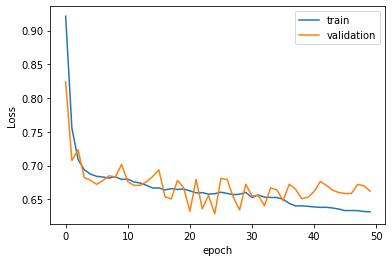

In [154]:
# summarize history for accuracy
plt.plot(lstm_resuls.history['loss'])
plt.plot(lstm_resuls.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

In [149]:
lstm_model.load_weights('./models/best_lstm_model.hdf5')
lstm_preds = lstm_model.predict(x_valid_reshaped)
lstm_preds = pd.Series([x[0] for x in lstm_preds], index = y_valid.index, name = 'lstm_preds')
lstm_preds.head()

bookingID
0     0.521096
4     0.494181
6     0.486724
11    0.328933
16    0.500799
Name: lstm_preds, dtype: float64

In [150]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_valid.label, lstm_preds)

0.6045279452523282

Previously, we train the model based on 50% data, and use the resulting model to make predictions on the last 50% data. <br>
Now, we do the opposite: train on the 50% validation data, and make predictions on the 50% first data. <br>
It is essentially 2-fold cross predictions, which are to make data for the stacked model.

In [151]:
random.seed(7)
np.random.seed(7)
tf.set_random_seed(7)


reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.2, min_lr=0.0001, verbose=0)
checkpoint_2 = ModelCheckpoint('./models/best_lstm_model_2.hdf5', verbose=0, monitor='val_loss',save_best_only=True, mode='min')
lstm_model_2 = Sequential()
lstm_model_2.add(LSTM(32, input_shape=(n_timestamps, n_cols), kernel_regularizer=regularizers.l2(0.005), return_sequences=True))
lstm_model_2.add(Dropout(0.4))
lstm_model_2.add(LSTM(8, kernel_regularizer=regularizers.l2(0.005), return_sequences=True))
lstm_model_2.add(Dropout(0.4))
lstm_model_2.add(LSTM(16, kernel_regularizer=regularizers.l2(0.005)))
lstm_model_2.add(Dropout(0.4))
lstm_model_2.add(Dense(1, activation='sigmoid'))
lstm_model_2.compile(loss='binary_crossentropy', optimizer=adam_opt, metrics=['accuracy'])


lstm_resuls_2 = lstm_model_2.fit(x_valid_reshaped, y_valid.label, epochs=50, batch_size=96,
                               validation_data = (x_train_reshaped, y_train.label), 
                               verbose = 0, callbacks=[reduce_lr, checkpoint_2], class_weight = class_weights_dict)


lstm_model_2.load_weights('./models/best_lstm_model_2.hdf5')
lstm_preds_2 = lstm_model_2.predict(x_train_reshaped)
lstm_preds_2 = pd.Series([x[0] for x in lstm_preds_2], index = y_train.index, name = 'lstm_preds')
lstm_preds = lstm_preds.append(lstm_preds_2).sort_index()
lstm_preds.head()

bookingID
0    0.521096
1    0.487462
2    0.421548
4    0.494181
6    0.486724
Name: lstm_preds, dtype: float64

Save the model:

In [152]:
not_useful_col = features_data_lstm.columns[features_data_lstm.columns.isin(['second', 'bookingID', 'high_accuracy', 'Accuracy', 'Bearing', 'Speed', 'timestamp', \
                                                      'speed_during_turning_x', 'speed_during_turning_y', 'speed_during_turning_z', 'speed_during_turning', \
                                                      'speed_during_high_accuracy', 'accel_x_raw_change', 'accel_y_raw_change', 'accel_z_raw_change', \
                                                      'acceleration_x', 'acceleration_y', 'acceleration_z', 'gyro_x', 'gyro_y', 'gyro_z'\
                                                      ])]
features_data_lstm_dropped = features_data_lstm.drop(not_useful_col, 1)


# Scale data:
import joblib
scaler = StandardScaler().fit(features_data_lstm_dropped)
joblib.dump(scaler, './models/seq_scaler.pkl')
features_data_lstm_scaled = scaler.transform(features_data_lstm_dropped)


# Reshape into 3D arrays:
# Train data:
n_obs = len(features_data_lstm.bookingID.unique())
n_cols = features_data_lstm_scaled.shape[1]
features_data_lstm_reshaped = np.array(features_data_lstm_scaled)
features_data_lstm_reshaped = features_data_lstm_reshaped.reshape(n_obs, n_timestamps, n_cols)
del features_data_lstm_dropped, features_data_lstm_scaled, not_useful_col

In [153]:
random.seed(7)
np.random.seed(7)
tf.set_random_seed(7)


reduce_lr = ReduceLROnPlateau(monitor='val_loss', mode='min', factor=0.2, min_lr=0.0001, verbose=0)
checkpoint_final = ModelCheckpoint('./models/best_final_lstm_model.hdf5', verbose=0, monitor='val_loss',save_best_only=True, mode='min')
lstm_model_final = Sequential()
lstm_model_final.add(LSTM(32, input_shape=(n_timestamps, n_cols), kernel_regularizer=regularizers.l2(0.005), return_sequences=True))
lstm_model_final.add(Dropout(0.4))
lstm_model_final.add(LSTM(8, kernel_regularizer=regularizers.l2(0.005), return_sequences=True))
lstm_model_final.add(Dropout(0.4))
lstm_model_final.add(LSTM(16, kernel_regularizer=regularizers.l2(0.005)))
lstm_model_final.add(Dropout(0.4))
lstm_model_final.add(Dense(1, activation='sigmoid'))
lstm_model_final.compile(loss='binary_crossentropy', optimizer=adam_opt, metrics=['accuracy'])


lstm_resuls_final = lstm_model_final.fit(features_data_lstm_reshaped, labels_data_clean.label, epochs=50, batch_size=96,
                               validation_split = 0.3, 
                               verbose = 0, callbacks=[reduce_lr, checkpoint_final], class_weight = class_weights_dict)

lstm_model_final.load_weights('./models/best_lstm_model_2.hdf5')
full_lstm_preds = lstm_model_final.predict(features_data_lstm_reshaped)
full_lstm_preds = pd.Series([x[0] for x in full_lstm_preds], index = labels_data_clean.index, name = 'full_lstm_preds')

## 4. Non-Sequential Learning:

### 4.1. Feature Engineering:

First, we extract relevant columns, from which we want to aggregate summary statistics.

In [70]:
features_data_sequential.columns

Index(['bookingID', 'Accuracy', 'Bearing', 'acceleration_x', 'acceleration_y',
       'acceleration_z', 'gyro_x', 'gyro_y', 'gyro_z', 'second', 'Speed',
       'positive_speed', 'imputed_speed', 'acceleration_total', 'gyro_total',
       'timestamp', 'rolling_acc_x', 'rolling_acc_y', 'rolling_acc_z',
       'rolling_acc_total', 'rolling_gyro_x', 'rolling_gyro_y',
       'rolling_gyro_z', 'rolling_gyro_total', 'rolling_speed',
       'bearing_change', 'rolling_bearing_change', 'speed_during_turning',
       'speed_during_turning_x', 'speed_during_turning_y',
       'speed_during_turning_z', 'speed_pct_change', 'accel_x_raw_change',
       'accel_y_raw_change', 'accel_z_raw_change', 'accel_total_raw_change',
       'high_accuracy'],
      dtype='object')

In [71]:
features_data_nonseq = features_data_sequential.drop(['timestamp', 'Accuracy', 'Speed', 'second', 'positive_speed', 'Bearing', 'high_accuracy'], axis = 1)
features_data_nonseq = features_data_nonseq.set_index('bookingID')
features_data_nonseq.head()

,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,imputed_speed,acceleration_total,gyro_total,rolling_acc_x,...,rolling_bearing_change,speed_during_turning,speed_during_turning_x,speed_during_turning_y,speed_during_turning_z,speed_pct_change,accel_x_raw_change,accel_y_raw_change,accel_z_raw_change,accel_total_raw_change
bookingID,,,,,,,,,,,,,,,,,,,,,
0,0.818112,-9.941461,-2.014999,-0.016245,-0.094040,0.070732,3.442991,10.176551,0.118788,0.818112,...,0.0,0.0,0.001154,0.004031,0.003673,0.000000,0.000000,0.000000,0.000000,0.000000
0,0.546405,-9.835590,-2.038925,-0.047092,-0.078874,0.043187,0.228454,10.059553,0.101508,0.682259,...,0.0,0.0,0.000222,0.000224,0.000149,-0.933647,-0.271707,0.105872,-0.023926,-0.116998
0,-1.706207,-9.270792,-1.209448,-0.028965,-0.032652,0.015390,0.228454,9.503762,0.046282,-0.113897,...,0.0,0.0,0.000137,0.000093,0.000053,0.000000,-2.252612,0.564798,0.829477,-0.555791
0,-1.416705,-9.548032,-1.860977,-0.022413,0.005049,-0.025753,0.228454,9.830320,0.034511,-0.439599,...,0.0,0.0,0.000106,0.000014,0.000089,0.000000,0.289502,-0.277240,-0.651529,0.326559
0,-0.598145,-9.853534,-1.378574,-0.014297,-0.046206,0.021902,0.228454,9.967466,0.053095,-0.471308,...,0.0,0.0,0.000067,0.000131,0.000075,0.000000,0.818561,-0.305502,0.482404,0.137145


The below code chunk would be a bit long, as it's more concise to aggregate all of our features in one go. <br>
Some basic features include: min, max, mean, median, standard deviation, range, mode, 25th percentile, 75th percentile, and 90th percentile. <br>
Noticably, we will use these aggregate features (some of them are inspired by financial industry!):
- Inter-quartile range: to observe the dispersion among the typical values, i.e. not taking outliers into account.
- Semi standard deviation: variance, but only among those above the mean. Its purpose is to observe the statistical dispersion like standard deviation, but only for the higher valuers. Low values (speed, accuracy) don't explain safety/danger as well as high values.
- Skewness and kurtosis: further insights into the distribution of different values. Skewness measures the tendency toward the left/right ends, while kurtosis measures the thickness of 2 ends compared to the middle part.
- Mean extreme value: defined as mean of values in top 10% percentile, to observe the typical extreme values of a distribution.

In [72]:
from scipy.stats import kurtosis, skew

def semi_std(series):
    mean = series.mean()
    high_val = series[series >= mean]
    n_obs = len(high_val)
    if n_obs == 1: return 0
    var = np.sum((high_val - mean)**2) / (n_obs - 1)
    return (var**0.5)


def mean_of_extreme_values(series):
    q95 = series.quantile(0.95, interpolation='midpoint')
    return series[series >= q95].mean()


def summary_statstics(x):
    result = []
    colnames = x.columns[x.columns != 'bookingID']
    agg_funcs = ['min', 'max', 'mean', 'median', 'std', 'q25', 'q75', 'skew', 'kurtosis', 'semi_std', 'mean_of_extreme_values']

    for col in colnames:
        if col in ['speed_during_turning', 'imputed_speed']:
            values = x[col][x[col] != 0]
        else:
            values = x[col]
        
        if values.empty:
            result.extend([0] * len(agg_funcs))
        else:
            result.append(values.min())
            result.append(values.max())        
            result.append(values.mean())
            result.append(values.quantile(0.5))
            result.append(np.std(values))      
            result.append(values.quantile(0.25))
            result.append(values.quantile(0.75))
            result.append(skew(values, bias = False))
            result.append(kurtosis(values, bias = False))
            result.append(semi_std(values))
            result.append(mean_of_extreme_values(values))
    
    return pd.Series(result, index=[[colname for colname in colnames.to_list() for repeat in range(len(agg_funcs))],
                                    [agg_func for repeat in range(len(colnames)) for agg_func in agg_funcs]])

features_data_nonseq_agg = features_data_nonseq.groupby(level = 0).apply(summary_statstics)
features_data_nonseq_agg.columns = features_data_nonseq_agg.columns.map('|'.join).str.strip('|')
features_data_nonseq_agg = features_data_nonseq_agg.sort_index()
features_data_nonseq_agg.loc[:, features_data_nonseq_agg.columns.str.contains('acceleration_x')].head()

,acceleration_x|min,acceleration_x|max,acceleration_x|mean,acceleration_x|median,acceleration_x|std,acceleration_x|q25,acceleration_x|q75,acceleration_x|skew,acceleration_x|kurtosis,acceleration_x|semi_std,acceleration_x|mean_of_extreme_values
bookingID,,,,,,,,,,,
0,-4.692294,4.782614,-0.711264,-0.725250,0.927560,-1.185149,-0.299371,0.362731,3.336609,0.965721,1.543972
1,-5.352994,3.813341,-0.525406,-0.563126,0.743719,-0.841121,-0.229374,0.525563,9.091471,0.800992,1.483237
2,-2.971295,1.956122,0.306786,0.433364,0.754647,-0.198725,0.824828,-0.745102,1.241046,0.627809,1.637923
4,-2.866458,2.019635,-0.365117,-0.381168,0.526979,-0.566518,-0.148863,-0.031936,4.435637,0.543930,0.956501
6,-4.352792,5.593026,0.490616,0.476461,0.825894,0.144854,0.762577,0.343528,5.990339,0.883322,2.614505


Calculate the mode of speed, defined as the highest-frequency speed bin of each trip:

In [73]:
features_data_nonseq_agg.to_csv('nonseq_agg_data_formal_resetid_short_allcols_noacc_speedexceptzero_combined.csv', index = True)

In [75]:
mode_speed = pd.Series(features_data_sequential[features_data_sequential.imputed_speed > 0].groupby('bookingID').imputed_speed.agg(lambda x: pd.Series.mode(x.astype('int'))[0]), name = 'imputed_speed|mode')
features_data_nonseq_agg = pd.concat([features_data_nonseq_agg, mode_speed], axis = 'columns', join_axes = [features_data_nonseq_agg.index])
del mode_speed
features_data_nonseq_agg['imputed_speed|mode'] = features_data_nonseq_agg['imputed_speed|mode'].fillna(0)
features_data_nonseq_agg[['imputed_speed|median', 'imputed_speed|mode']].head()

,imputed_speed|median,imputed_speed|mode
bookingID,,
0,8.522352,0.0
1,10.793657,18.0
2,4.648966,5.0
4,3.560000,2.0
6,7.896908,12.0


We can also look at trip length:

In [76]:
trip_length = pd.Series(features_data_sequential.groupby('bookingID').second.max(), name = 'trip_length')
features_data_nonseq_agg = pd.concat([features_data_nonseq_agg, trip_length], axis = 'columns', join_axes = [features_data_nonseq_agg.index])
features_data_nonseq_agg['triplength_x_speed'] = features_data_nonseq_agg.trip_length * features_data_nonseq_agg['imputed_speed|mean']
del trip_length
features_data_nonseq_agg.head(10)

,acceleration_x|min,acceleration_x|max,acceleration_x|mean,acceleration_x|median,acceleration_x|std,acceleration_x|q25,acceleration_x|q75,acceleration_x|skew,acceleration_x|kurtosis,acceleration_x|semi_std,...,accel_total_raw_change|std,accel_total_raw_change|q25,accel_total_raw_change|q75,accel_total_raw_change|skew,accel_total_raw_change|kurtosis,accel_total_raw_change|semi_std,accel_total_raw_change|mean_of_extreme_values,imputed_speed|mode,trip_length,triplength_x_speed
bookingID,,,,,,,,,,,,,,,,,,,,,
0,-4.692294,4.782614,-0.711264,-0.725250,0.927560,-1.185149,-0.299371,0.362731,3.336609,0.965721,...,0.873370,-0.391023,0.380521,0.161356,2.761302,0.871036,2.078154,0.0,1589.0,14308.606323
1,-5.352994,3.813341,-0.525406,-0.563126,0.743719,-0.841121,-0.229374,0.525563,9.091471,0.800992,...,0.745980,-0.352528,0.365167,-0.090026,2.126860,0.728962,1.696869,18.0,1034.0,11317.132076
2,-2.971295,1.956122,0.306786,0.433364,0.754647,-0.198725,0.824828,-0.745102,1.241046,0.627809,...,0.787240,-0.223288,0.241706,-0.484809,9.585064,0.742929,1.815950,5.0,825.0,3790.422653
4,-2.866458,2.019635,-0.365117,-0.381168,0.526979,-0.566518,-0.148863,-0.031936,4.435637,0.543930,...,0.876379,-0.284075,0.293990,0.930513,61.460166,0.896042,1.884669,2.0,1094.0,7011.175111
6,-4.352792,5.593026,0.490616,0.476461,0.825894,0.144854,0.762577,0.343528,5.990339,0.883322,...,0.796030,-0.371658,0.360906,-0.158557,4.210586,0.788502,1.889028,12.0,1094.0,8517.855497
7,-3.439000,4.715000,1.327679,1.386000,0.945441,0.905000,1.849000,-0.567794,2.266526,0.840729,...,1.223004,-0.601311,0.579479,-0.145969,2.819814,1.199212,2.767020,22.0,959.0,14914.696291
8,-4.280777,0.696777,-1.197008,-1.106674,0.611003,-1.446640,-0.966904,-0.682901,3.820433,0.510288,...,1.034220,-0.318946,0.266021,0.703226,17.227625,1.095475,2.533945,3.0,462.0,3408.178932
10,-4.353851,5.021835,0.954849,0.922958,1.236916,0.563835,1.517326,-0.528408,2.923442,1.228939,...,1.199209,-0.575184,0.506177,0.173773,2.826783,1.256823,2.878510,16.0,374.0,4358.783000
11,-2.502017,4.877138,0.564240,0.495615,1.189789,-0.033520,1.139675,0.407111,1.132230,1.318875,...,1.067710,-0.414222,0.562151,-0.729562,2.687244,1.019457,2.097166,2.0,299.0,2574.631124


For categorical features, say negative speed, we will compute the percentage of negative-speed data points within each trip. <br>
The same calculation is done for high accuracy feature.

In [77]:
perc_negative_speed = pd.Series((1 - features_data_sequential.groupby('bookingID').positive_speed.mean()), name = 'perc_negative_speed')
features_data_nonseq_agg = pd.concat([features_data_nonseq_agg, perc_negative_speed], axis = 'columns', join_axes = [features_data_nonseq_agg.index])

perc_high_accuracy = pd.Series((1 - features_data_sequential.groupby('bookingID').high_accuracy.mean()), name = 'perc_high_accuracy')
features_data_nonseq_agg = pd.concat([features_data_nonseq_agg, perc_high_accuracy], axis = 'columns', join_axes = [features_data_nonseq_agg.index])

del perc_negative_speed, perc_high_accuracy
features_data_nonseq_agg[['perc_negative_speed', 'perc_high_accuracy']].head()

,perc_negative_speed,perc_high_accuracy
bookingID,,
0,0.000996,0.756972
1,0.015276,1.000000
2,0.000000,1.000000
4,0.000000,1.000000
6,0.000000,1.000000


In [78]:
accuracy_65 = pd.Series(np.where(features_data_sequential.Accuracy == 65, 1, 0))
wifi_gps = pd.Series(accuracy_65.groupby(features_data_sequential.bookingID).mean(), name = 'wifi_gps')
features_data_nonseq_agg = pd.concat([features_data_nonseq_agg, wifi_gps], axis = 'columns', join_axes = [features_data_nonseq_agg.index])

accuracy_1414 = pd.Series(np.where(features_data_sequential.Accuracy == 1414, 1, 0))
cell_gps = pd.Series(accuracy_1414.groupby(features_data_sequential.bookingID).mean(), name = 'cell_gps')
features_data_nonseq_agg = pd.concat([features_data_nonseq_agg, cell_gps], axis = 'columns', join_axes = [features_data_nonseq_agg.index])

features_data_nonseq_agg[['wifi_gps', 'cell_gps']].head()

,wifi_gps,cell_gps
bookingID,,
0,0.0,0.0
1,0.0,0.0
2,0.0,0.0
4,0.0,0.0
6,0.0,0.0


We also calculate the time interval of each trip:

In [79]:
time_interval = features_data_sequential.second.diff()
time_interval[features_data_sequential.second == 0] = 0
max_time_interval = pd.Series(time_interval.groupby(features_data_sequential.bookingID).max(), name = 'max_time_interval')
features_data_nonseq_agg = pd.concat([features_data_nonseq_agg, max_time_interval], axis = 'columns', join_axes = [features_data_nonseq_agg.index])
del time_interval, max_time_interval
features_data_nonseq_agg['max_time_interval'].head()

bookingID
0    586.0
1    181.0
2    631.0
4      2.0
6      1.0
Name: max_time_interval, dtype: float64

### 4.2. Non-sequential Model:

In this part. we attempt to visit 4 different models:
- K-Nearest neighbors
- Elastic net logistic regression
- Random forest
- XGBoost

The models are chosen based on how they differ from each other, as well as their practical performances. 

Load libraries:

In [80]:
from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

Prepare training data:

In [82]:
preProcess = StandardScaler().fit(features_data_nonseq_agg)
joblib.dump(preProcess, './models/nonseq_scaler.pkl')
train_features = preProcess.transform(features_data_nonseq_agg)
train_labels = labels_data_clean.label.tolist()
print(train_features.shape)

(20000, 327)


Train Nearest Neighbors Model:

In [83]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(n_neighbors = 100, weights = 'distance')
model_score = np.mean(cross_val_score(knn_model, train_features, train_labels, cv=5, scoring="roc_auc"))
print('loss: ', model_score)

loss:  0.661999579073122


In [84]:
from sklearn.model_selection import cross_val_predict
np.random.seed(777)

final_knn_model = knn_model
knn_preds = cross_val_predict(final_knn_model, train_features, train_labels, cv = 5, method = 'predict_proba')
knn_preds = [x[1]*3/(x[1]*3 + x[0]) for x in knn_preds]
knn_preds = pd.Series(knn_preds, name = 'knn_preds', index = labels_data_clean.index)

Train elastic net logistic regression:

In [85]:
from sklearn.linear_model import SGDClassifier

def objective(space):
    enet_model = SGDClassifier(loss="log", penalty="elasticnet", class_weight = 'balanced',
                               alpha  = space['alpha'],
                               l1_ratio = space['l1_ratio']
                              )

    model_score = -np.mean(cross_val_score(enet_model, train_features, train_labels, cv=5, scoring="roc_auc"))
    return{'loss': model_score, 'status': STATUS_OK, 'model': enet_model}

space = {
        'alpha': hp.uniform ('alpha', 0.0001, 0.05),
        'l1_ratio': hp.uniform ('l1_ratio', 0, 0.5)
        }

enet_trials = Trials()
enet_best = fmin(fn = objective,
                space = space,
                algo = tpe.suggest,
                max_evals = 150,
                trials = enet_trials,
                rstate = np.random.RandomState(777))

print(enet_best)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [11:17<00:00,  5.08s/it, best loss: -0.7296993638217067]
{'alpha': 0.005898716013399793, 'l1_ratio': 0.1100196059017814}


In [86]:
np.random.seed(777)
final_enet_model = enet_trials.best_trial['result']['model']
enet_preds = cross_val_predict(final_enet_model, train_features, train_labels, cv = 5, method = 'predict_proba')
enet_preds = [x[1] for x in enet_preds]
enet_preds = pd.Series(enet_preds, name = 'enet_preds', index = labels_data_clean.index)

final_enet_model.fit(train_features, train_labels)
reg_coefs = pd.DataFrame(final_enet_model.coef_.transpose(), features_data_nonseq_agg.columns, columns=['coefficients'])
print(reg_coefs.sort_values('coefficients', ascending = False).head(20))

                                       coefficients
trip_length                                0.461110
triplength_x_speed                         0.406274
acceleration_z|std                         0.272810
imputed_speed|max                          0.214418
max_time_interval                          0.195240
acceleration_x|std                         0.165257
imputed_speed|skew                         0.160843
acceleration_z|semi_std                    0.080464
bearing_change|max                         0.072662
rolling_acc_total|std                      0.072463
speed_during_turning_y|median              0.070357
rolling_gyro_x|q75                         0.067052
speed_during_turning_y|skew                0.063734
acceleration_total|semi_std                0.063259
accel_x_raw_change|q25                     0.060513
rolling_bearing_change|kurtosis            0.057061
acceleration_z|mean_of_extreme_values      0.055496
acceleration_total|std                     0.055194
acceleration

Train random forest:

In [87]:
from sklearn.ensemble import RandomForestClassifier

def objective(space):
    rf_model = RandomForestClassifier(n_estimators = 50, class_weight = 'balanced',  n_jobs = -1,
                                      max_features = int(space['max_features']),
                                      criterion = space['criterion'],
                                      min_samples_leaf  = space['min_samples_leaf'],
                                      max_depth = 6)
                                      

    model_score = -np.mean(cross_val_score(rf_model, train_features, train_labels, cv=5, scoring="roc_auc"))
    return{'loss': model_score, 'status': STATUS_OK, 'model': rf_model}

space = {'max_features': hp.quniform('max_features', 1, len(train_features[0]), 1), 
         'criterion': hp.choice('criterion', ["gini", "entropy"]), 
         'min_samples_leaf': hp.uniform('min_samples_leaf', 0.001, 0.1)}

rf_trials = Trials()
rf_best = fmin(fn = objective, 
               space = space, 
               algo = tpe.suggest, 
               max_evals = 50, 
               trials = rf_trials, 
               rstate = np.random.RandomState(777))

print(rf_best)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [35:29<00:00, 37.74s/it, best loss: -0.730330416600039]
{'criterion': 0, 'max_features': 212.0, 'min_samples_leaf': 0.001418124780954919}


In [88]:
np.random.seed(777)
final_rf_model = rf_trials.best_trial['result']['model']
rf_preds = cross_val_predict(final_rf_model, train_features, train_labels, cv = 5, method = 'predict_proba')
rf_preds = [x[1] for x in rf_preds]
rf_preds = pd.Series(rf_preds, name = 'rf_preds', index = labels_data_clean.index)

Train XGBoost model:

In [89]:
# import os
# os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier

def objective(space):
    xgb_model = XGBClassifier(objective='binary:logistic', scale_pos_weight = 3,
                                  max_depth = 6,
                                  min_child_weight = space['min_child_weight'],
                                  subsample = space['subsample'],
                                  n_estimators = 100,
                                  learning_rate = space['learning_rate'],
                                  gamma = space['gamma'],
                                  colsample_bytree = space['colsample_bytree']
                                 )

    model_score = -np.mean(cross_val_score(xgb_model, train_features, train_labels, cv=4, scoring="roc_auc"))
    return{'loss': model_score, 'status': STATUS_OK, 'model': xgb_model}

space ={
        'min_child_weight': hp.choice ('min_child', range(5, 15)),
        'subsample': hp.uniform ('subsample', 0.7, 0.9),
        'learning_rate' : hp.uniform('learning_rate', 0.02, 0.1),
        'gamma' : hp.uniform('gamma', 0.3, 0.5),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.7, 0.9)}

                                         
xgb_trials = Trials()
xgb_best = fmin(fn = objective,
                space = space,
                algo = tpe.suggest,
                max_evals = 50,
                trials = xgb_trials)

print(xgb_best)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [2:43:19<00:00, 199.56s/it, best loss: -0.7335694978565126]
{'colsample_bytree': 0.84973162413131, 'gamma': 0.3936073472655571, 'learning_rate': 0.03360871748831629, 'min_child': 5, 'subsample': 0.7913596429937221}


In [90]:
np.random.seed(777)
final_xgb_model = xgb_trials.best_trial['result']['model']
xgb_preds = cross_val_predict(final_xgb_model, train_features, train_labels, cv = 5, method = 'predict_proba')
xgb_preds = [x[1] for x in xgb_preds]
xgb_preds = pd.Series(xgb_preds, name = 'xgb_preds', index = labels_data_clean.index)

## 5. Stacking:

In [155]:
stacked_model_data = labels_data_clean.copy()
stacked_model_data = pd.concat([stacked_model_data, lstm_preds, knn_preds, enet_preds, rf_preds, xgb_preds], axis = 'columns', join_axes = [labels_data_clean.index])
stacked_model_data.head()

,label,lstm_preds,knn_preds,enet_preds,rf_preds,xgb_preds
bookingID,,,,,,
0,0,0.521096,0.571640,0.808840,0.593423,0.542832
1,1,0.487462,0.359623,0.503655,0.495449,0.528472
2,1,0.421548,0.512834,0.570976,0.556158,0.572218
4,1,0.494181,0.413108,0.570520,0.443338,0.414062
6,0,0.486724,0.457917,0.509653,0.488415,0.460607


In [156]:
from sklearn.linear_model import LogisticRegression

def objective(space):
    stacked_model = LogisticRegression (penalty='elasticnet', class_weight = 'balanced', solver = 'saga', random_state = 9,
                                        C = max(1, space['C']),
                                        l1_ratio = space['l1_ratio']
                                       )

    model_score = -np.mean(cross_val_score(stacked_model, stacked_model_data.drop('label', axis = 1), stacked_model_data.label, cv=5, scoring="roc_auc"))
    return{'loss': model_score, 'status': STATUS_OK, 'model': stacked_model}

space ={
        'C': hp.uniform('C', 1, 5),
        'l1_ratio': hp.uniform ('l1_ratio', 0, 1)}

                                         
stacked_trials = Trials()
stacked_best = fmin(fn = objective,
                space = space,
                algo = tpe.suggest,
                max_evals = 200,
                trials = stacked_trials)

print(stacked_best)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [01:16<00:00,  2.64it/s, best loss: -0.7362782148183482]
{'C': 4.775779932775844, 'l1_ratio': 0.5950290011973922}


In [157]:
from sklearn.metrics import roc_auc_score

final_stacked_model = stacked_trials.best_trial['result']['model']
final_stacked_model.fit(stacked_model_data.drop('label', axis = 1), stacked_model_data.label)
stacked_preds = final_stacked_model.predict_proba(stacked_model_data.drop('label', axis = 1))
stacked_preds = [x[1] for x in stacked_preds]
joblib.dump(final_stacked_model, './models/final_stacked_model.pkl')

roc_auc_score(labels_data_clean.label, stacked_preds)

0.7362544158946063

### 3.3. Compiling and saving models:

Fit individual models on the entire data set:

In [158]:
final_knn_model.fit(train_features, train_labels)
final_enet_model.fit(train_features, train_labels)
final_rf_model.fit(train_features, train_labels)
final_xgb_model.fit(train_features, train_labels)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.84973162413131,
              gamma=0.3936073472655571, learning_rate=0.03360871748831629,
              max_delta_step=0, max_depth=6, min_child_weight=10, missing=None,
              n_estimators=100, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=3, seed=None, silent=None,
              subsample=0.7913596429937221, verbosity=1)

Save individual models:

In [159]:
joblib.dump(final_knn_model, './models/final_knn_model.pkl')
joblib.dump(final_enet_model, './models/final_enet_model.pkl')
joblib.dump(final_rf_model, './models/final_rf_model.pkl')
joblib.dump(final_xgb_model, './models/final_xgb_model.pkl')

['./models/final_xgb_model.pkl']